# DataChallenge

## Librairies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from tqdm import tqdm

## Parameters, Hyperparameters, Seed

In [3]:
seed = 42 # We fix the seed for reproducibility
train = None
drop = None

## Metric

In [4]:
def metric(y_true, y_pred):
    f = 1 + 0.2 * (y_true >= 0.5)              # pondère les cas où la vraie valeur est positive
    diff = (y_true - y_pred) ** 2              # erreur quadratique
    weighted = f * diff                        # pondération appliquée
    errors = np.mean(weighted, axis=1)         # moyenne par ligne
    final_error = np.sqrt(np.mean(errors))     # racine de la moyenne
    return final_error

In [5]:
def modif_predictions(y_pred, alpha=1.1, threshold=0.48, floor=0.5):
    y_pred = np.clip(y_pred, 0, 1)
    y_pred *= alpha
    y_pred = np.where(y_pred <= threshold, y_pred, np.maximum(y_pred, floor))
    return y_pred

## Data Collection

In [6]:
X = pd.read_csv("x_train_T9QMMVq.csv")
print(f"Dimension of the dataset: {X.shape}")
y = pd.read_csv("y_train_R0MqWmu.csv")
print(f"Dimension of the response vector: {y.shape}")

Dimension of the dataset: (202933, 14)
Dimension of the response vector: (202933, 24)


### Train Val Test split

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(121759, 14) (121759, 24)
(40587, 14) (40587, 24)
(40587, 14) (40587, 24)


## Data Processing

### X_train

In [8]:
print(X_train.shape)
print(X_train.head())

(121759, 14)
            ID  Humidity        M12        M13       M14       M15         M4  \
128170  128170  0.000372 -12.128918 -10.038685 -6.692085 -2.725931   2.924100   
10157    10157  0.156735  -0.169991  -0.140449 -0.083268 -0.019521   0.093979   
158118  158118  0.000401   0.403388   0.285006  0.180356  0.148441  -0.041564   
162649  162649  0.867754  -0.032406  -0.026868 -0.029439 -0.005143   0.050611   
36537    36537  0.107927  -1.907945  -1.233831 -0.635659 -0.256506  18.939984   

               M5        M6        M7         R        S1        S2        S3  
128170   0.922374  0.197055  0.031729  0.546034  0.188495  0.928271  0.996086  
10157    0.074284  0.058909  0.016066  1.477164  0.935686  0.891420  1.001477  
158118   0.091291  0.099827  0.126175  1.731135  0.838978  0.938475  0.993774  
162649   0.010286  0.005586 -0.010552  1.004967  1.000340  1.001243  1.000757  
36537   15.370123  8.200569  3.632963  0.637185  0.623612  0.984508  1.011588  


In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 121759 entries, 128170 to 121958
Data columns (total 14 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ID        121759 non-null  int64  
 1   Humidity  121759 non-null  float64
 2   M12       121759 non-null  float64
 3   M13       121759 non-null  float64
 4   M14       121759 non-null  float64
 5   M15       121759 non-null  float64
 6   M4        121759 non-null  float64
 7   M5        121759 non-null  float64
 8   M6        121759 non-null  float64
 9   M7        121759 non-null  float64
 10  R         121759 non-null  float64
 11  S1        121759 non-null  float64
 12  S2        121759 non-null  float64
 13  S3        121759 non-null  float64
dtypes: float64(13), int64(1)
memory usage: 13.9 MB


In [10]:
X_train.describe()

,ID,Humidity,M12,M13,M14,M15,M4,M5,M6,M7,R,S1,S2,S3
count,121759.00000,121759.000000,121759.000000,121759.000000,121759.000000,121759.000000,121759.000000,121759.000000,121759.000000,121759.000000,121759.000000,121759.000000,121759.000000,121759.000000
mean,101166.39354,0.226024,-0.302691,-0.252570,-0.158379,-0.049869,0.893332,0.456441,0.176060,0.081094,1.187444,0.859954,1.015979,1.000663
std,58557.13063,0.335576,1.438756,1.262234,0.859582,0.366330,2.444375,1.588116,0.820825,0.395264,1.814315,0.304501,1.209001,0.023637
min,1.00000,0.000305,-13.001500,-11.844691,-9.117980,-4.165993,-2.831466,-0.790972,-0.224497,-0.147250,0.023324,0.026342,0.151214,0.710207
25%,50526.50000,0.000379,-0.288268,-0.179096,-0.087370,-0.032232,-0.051793,-0.006568,0.001832,0.001548,0.973668,0.773594,0.959204,0.996255
50%,101083.00000,0.091472,-0.000501,0.018813,0.019833,0.012872,0.158831,0.067450,0.035869,0.025857,1.014378,0.931893,0.988181,0.999959
75%,151732.50000,0.329776,0.209989,0.177158,0.120979,0.067191,0.658116,0.261005,0.120237,0.076767,1.120281,0.999396,1.000287,1.008612
max,202931.00000,0.958255,2.545019,2.864641,2.004906,0.842932,28.245698,28.710670,20.508550,10.714200,48.026927,6.626481,55.702963,1.057846


In [11]:
X_train.nunique()

ID          121759
Humidity     56406
M12          13601
M13          11002
M14           7803
M15           4290
M4           19604
M5           12213
M6            5938
M7            3340
R            99080
S1           58100
S2           39086
S3           16104
dtype: int64

There are many duplicates.

In [12]:
X_train.isnull().sum()

ID          0
Humidity    0
M12         0
M13         0
M14         0
M15         0
M4          0
M5          0
M6          0
M7          0
R           0
S1          0
S2          0
S3          0
dtype: int64

In [13]:
# Find out if there is at least one missing value 
null = X_train.isnull().values
if null.any() >=1 :
    count = len(X_train[X_train.isnull().any(axis=1)])
    print(f"Number of rows with at least one missing value: {count}")
    proportion = count / len(X_train) * 100
    print(f"Proportion of rows with missing values in the dataset: {np.round(proportion,2)}")
else:
    print("There is no missing value.")

There is no missing value.


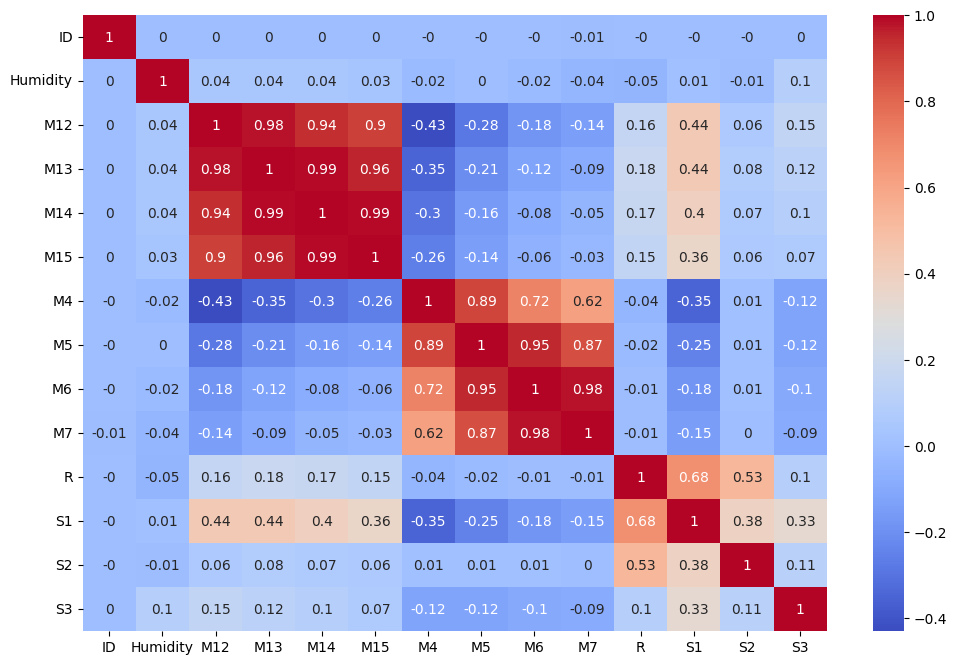

In [14]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(X_train.corr().round(2), cmap="coolwarm", annot=True, annot_kws={"size":10})
plt.show()

There are many highly correlated variables.

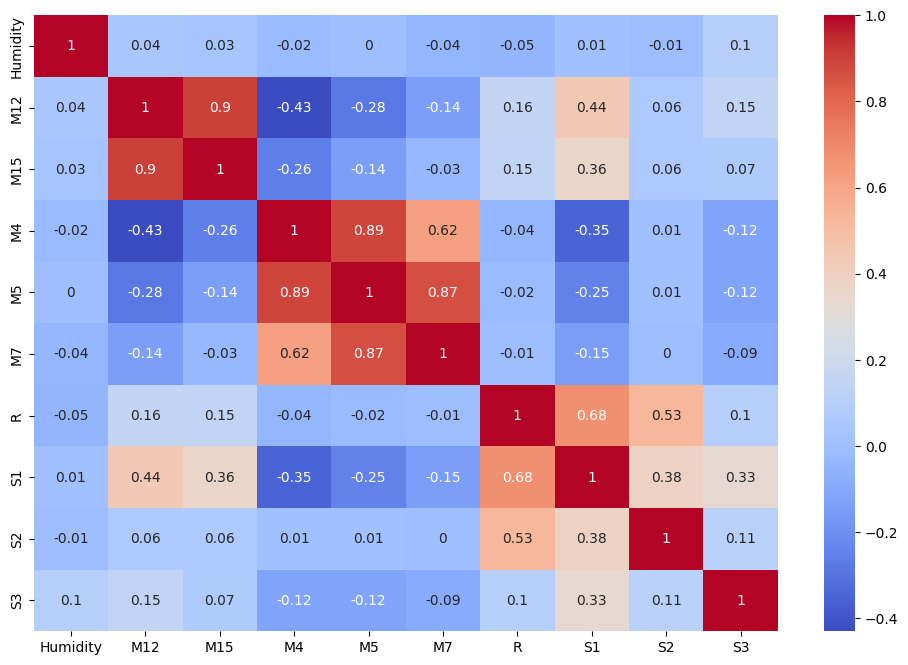

In [15]:
data = X_train.copy()
remove_col = ["M13","M14","M6"]
data = data.drop(["ID"] + remove_col, axis = 1)
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr().round(2), cmap="coolwarm", annot=True, annot_kws={"size":10})
plt.show()

### y_train

In [16]:
print(y_train.shape)
print(y_train.head())

(121759, 24)
            ID       c01  c02       c03       c04  c05  c06  c07  c08  c09  \
128170  128170  0.996036  0.0  0.996036  0.996036  0.0  0.0  0.0  0.0  0.0   
10157    10157  0.538560  0.0  0.538560  0.538560  0.0  0.0  0.0  0.0  0.0   
158118  158118  0.742687  0.0  0.742687  0.742687  0.0  0.0  0.0  0.0  0.0   
162649  162649  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
36537    36537  0.000000  0.0  1.000000  1.000000  0.0  0.0  0.0  0.0  0.0   

        ...  c14  c15  c16  c17       c18  c19  c20  c21       c22  c23  
128170  ...  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.996036  0.0  
10157   ...  0.0  0.0  0.0  0.0  0.538560  0.0  0.0  0.0  0.538560  0.0  
158118  ...  0.0  0.0  0.0  0.0  0.742687  0.0  0.0  0.0  0.742687  0.0  
162649  ...  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  0.0  
36537   ...  0.0  0.0  0.0  0.0  0.000000  1.0  0.0  0.0  1.000000  0.0  

[5 rows x 24 columns]


In [25]:
y_train.nunique()

ID     121759
c01     58985
c02     17709
c03     94426
c04     94426
c05      6192
c06      6192
c07     17709
c08      1186
c09      3130
c10     16604
c11     14389
c12     23614
c13     17128
c14     22622
c15         1
c16       683
c17      5327
c18     23970
c19      2523
c20     17709
c21      6192
c22     94426
c23      5952
dtype: int64

C15 a toujours la même valeur,....

In [26]:
y_train.isnull().sum()

ID     0
c01    0
c02    0
c03    0
c04    0
c05    0
c06    0
c07    0
c08    0
c09    0
c10    0
c11    0
c12    0
c13    0
c14    0
c15    0
c16    0
c17    0
c18    0
c19    0
c20    0
c21    0
c22    0
c23    0
dtype: int64

In [17]:
# Find out if there is at least one missing value 
null = y_train.isnull().values
if null.any() >=1 :
    count = len(y_train[y_train.isnull().any(axis=1)])
    print(f"Number of rows with at least one missing value: {count}")
    proportion = count / len(y_train) * 100
    print(f"Proportion of rows with missing values in the dataset: {np.round(proportion,2)}")
else:
    print("There is no missing value.")

There is no missing value.


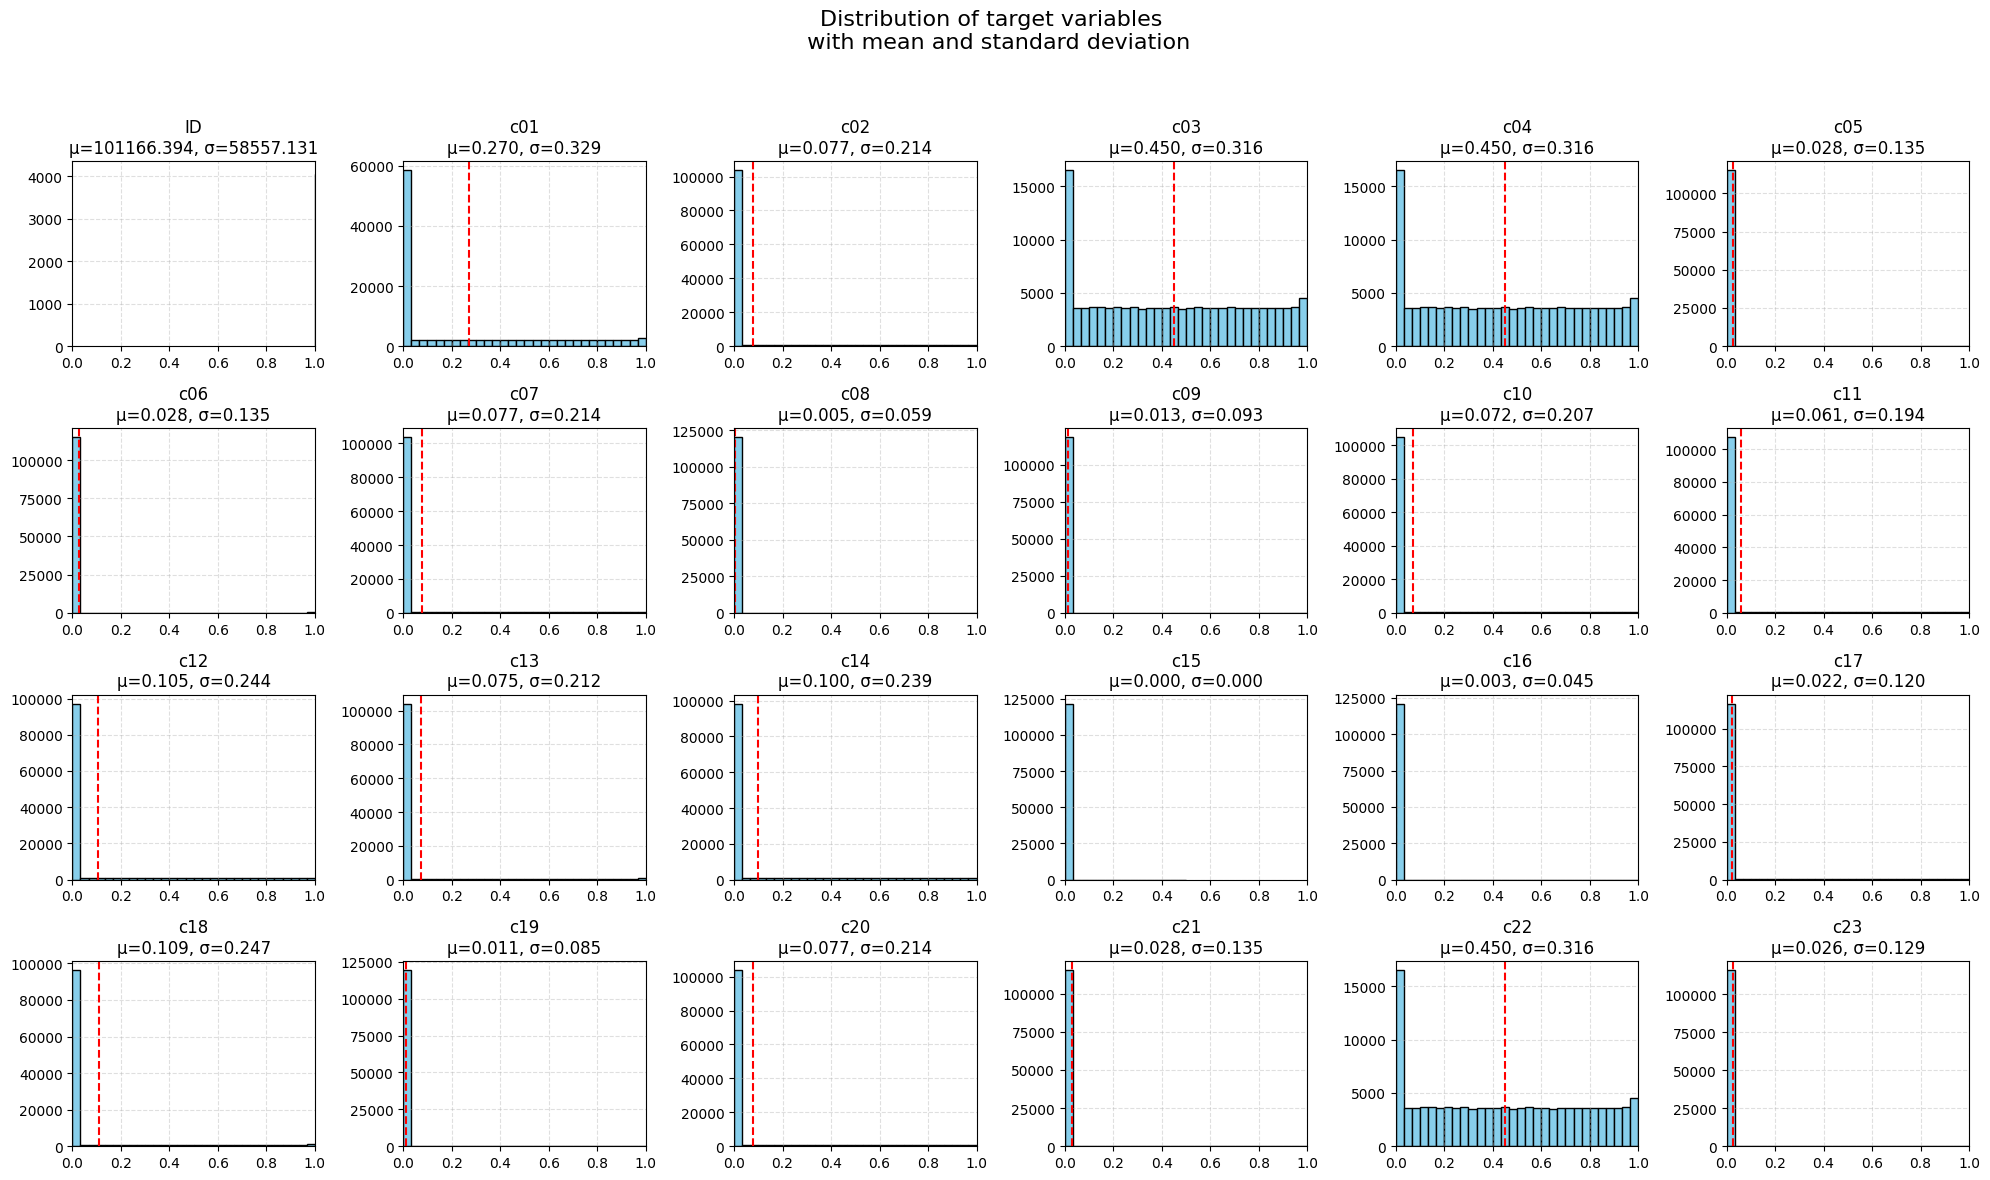

In [21]:
# Number of target columns
n_targets = y_train.shape[1]

# Creating a sub-graph grid
fig, axes = plt.subplots(4, 6, figsize=(20, 12))
axes = axes.ravel()

# Loop on each target variable
for i, col in enumerate(y_train.columns):
    data = y_train[col].dropna()
    
    mean_val = data.mean()
    std_val = data.std()
    
    axes[i].hist(data, bins=30, color='skyblue', edgecolor='black')
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label='Moyenne')
    
    axes[i].set_title(f"{col}\nμ={mean_val:.3f}, σ={std_val:.3f}")
    axes[i].set_xlim(0, 1)  # useful because these are probabilities
    axes[i].grid(True, linestyle='--', alpha=0.4)

# If there are less than 24 variables, remove the empty axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribution of target variables \n with mean and standard deviation", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Certaines variables devraient être traitées différemment des autres. En particulier, les prédictions des variables cibles ayant que des petites valeurs n'ont pas besoin de la même modification que celles ayant des valeurs proches de 0.5,...

### Data processing function

In [117]:
def data_processing(X, y=None, train=None):
    X = X.copy()
    X.set_index("ID", inplace=True)

    # Not a good idea
    if drop is not None:
        X.drop(remove_col, axis = 1, inplace=True)
        
    if y is not None:
        y = y.copy()
        y.set_index("ID", inplace=True)

        # Not a good idea
        if train is not None:
            mask = (y != 0).any(axis=1)
            X = X[mask]
            y = y[mask]
            
        return X, y
    else:
        return X

In [118]:
X_train, y_train = data_processing(X_train, y_train, train)
print(X_train.shape, y_train.shape)
print(X_train.head())

(121759, 13) (121759, 23)
        Humidity        M12        M13       M14       M15         M4  \
ID                                                                      
128170  0.000372 -12.128918 -10.038685 -6.692085 -2.725931   2.924100   
10157   0.156735  -0.169991  -0.140449 -0.083268 -0.019521   0.093979   
158118  0.000401   0.403388   0.285006  0.180356  0.148441  -0.041564   
162649  0.867754  -0.032406  -0.026868 -0.029439 -0.005143   0.050611   
36537   0.107927  -1.907945  -1.233831 -0.635659 -0.256506  18.939984   

               M5        M6        M7         R        S1        S2        S3  
ID                                                                             
128170   0.922374  0.197055  0.031729  0.546034  0.188495  0.928271  0.996086  
10157    0.074284  0.058909  0.016066  1.477164  0.935686  0.891420  1.001477  
158118   0.091291  0.099827  0.126175  1.731135  0.838978  0.938475  0.993774  
162649   0.010286  0.005586 -0.010552  1.004967  1.000340  1.0

In [119]:
X_val, y_val = data_processing(X_val, y_val)
X_test, y_test = data_processing(X_test, y_test)

## Data Pre-processing

In [120]:
def pre_processing(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test

In [121]:
_ , X_val = pre_processing(X_train, X_val)
X_train, X_test = pre_processing(X_train, X_test)

## Models

In [122]:
def Linear_model(X_train, y_train, X_test, y_test=None):
    mod = LinearRegression()
    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    y_pred_clipped = np.clip(y_pred, 0, 1)
    if y_test is not None:
        metric_value = metric(y_test, y_pred_clipped)
        return y_pred, metric_value, mod
    else:
        return y_pred_clipped, mod

In [123]:
def Adaboost(X_train, y_train, X_test, y_test=None, n_estimators = 50, learning_rate = 1.0):
    mod = AdaBoostRegressor(n_estimators = n_estimators, learning_rate = learning_rate, random_state=seed)
    model = MultiOutputRegressor(mod, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_clipped = np.clip(y_pred, 0, 1)
    if y_test is not None:
        metric_value = metric(y_test, y_pred_clipped)
        return y_pred, metric_value, model
    else:
        return y_pred_clipped, model

In [124]:
y_pred, metric_value, mod = Linear_model(X_train, y_train, X_val, y_val)
print(metric_value)

0.17584634177358502


In [ ]:
# y_pred_Adaboost, metric_value, mod = Adaboost(X_train, y_train, X_val, y_val)
# print(metric_value)
# 0.15021239825765786

0.15021239825765786


Our best model is Adaboost.

## Calibration of hyper-parameters

In [ ]:
# Define parameter combinations to test
param_grid = {
    'n_estimators': [30],
    'learning_rate': [0.25, 0.3]
}
# base_estimator = DecisionTreeRegressor(max_depth=3)

best_score = np.inf
best_params = None
best_model = None

# Total number of combinations
total = len(param_grid["n_estimators"]) * len(param_grid["learning_rate"])

# Manual buckle
with tqdm(total=total, desc="Grid search") as pbar:
    for estimator in param_grid["n_estimators"]:
        for lr in param_grid["learning_rate"]:
            print(f"⏳ Test with n_estimators={estimator}, learning_rate={lr}")
        
            # Create the model
            ada = MultiOutputRegressor(
                AdaBoostRegressor(
                    # base_estimator=base_estimator,
                    n_estimators=estimator,
                    learning_rate=lr,
                    random_state=seed
                ),
                n_jobs=-1
            )
        
            # Training
            ada.fit(X_train, y_train)
        
            # Evaluation on validation
            y_val_pred = ada.predict(X_val)
            y_val_pred_clipped = np.clip(y_val_pred, 0, 1)
            score = metric(y_val, y_val_pred_clipped)
        
            print(f"➡️ Metric value : {score:.4f}")
        
            # Save the best
            if score < best_score:
                best_score = score
                best_params = {"n_estimators": estimator, "learning_rate": lr}
                best_model = ada
            
            # Move the bar forward
            pbar.update(1)

print("✅ Best parameters :", best_params)
print("✅ Best score :", best_score)

Grid search:   0%|          | 0/2 [00:00<?, ?it/s]

⏳ Test with n_estimators=40, learning_rate=0.2


Grid search:  50%|█████     | 1/2 [02:09<02:09, 129.18s/it]

➡️ Metric value : 0.1331
⏳ Test with n_estimators=40, learning_rate=0.25


Grid search: 100%|██████████| 2/2 [04:11<00:00, 125.70s/it]

➡️ Metric value : 0.1336
✅ Best parameters : {'n_estimators': 40, 'learning_rate': 0.2}
✅ Best score : 0.13307788883933627


In [127]:
y_val_pred = best_model.predict(X_val)

alphas = [0.9, 0.95, 1.0, 1.05, 1.2] 
thresholds = [0.35, 0.4, 0.45, 0.5] 
floors = [0.5, 0.6, 0.65, 0.7] 

best_score_modif = best_score
best_params_metric = {}

for alpha in alphas:
    for threshold in thresholds:
        for floor in floors:
            y_pp = modif_predictions(y_val_pred, alpha, threshold, floor)
            score = metric(y_val, y_pp)
            if score < best_score_modif:
                best_score_modif = score
                best_params_metric = {"alpha": alpha, "threshold": threshold, "floor": floor}

print("✅ Best combination :", best_params_metric)
print("✅ Best score :", best_score_modif)


✅ Best combination : {'alpha': 0.95, 'threshold': 0.4, 'floor': 0.65}
✅ Best score : 0.13019250403503663


In [128]:
alpha = best_params_metric["alpha"]
threshold = best_params_metric["threshold"]
floor = best_params_metric["floor"]
print(alpha, threshold, floor)

0.95 0.4 0.65


## Evaluation of the model on the test

In [129]:
y_test_pred = best_model.predict(X_test)
y_test_pred_clipped = np.clip(y_test_pred, 0, 1)
y_test_pred_modif = modif_predictions(y_test_pred, alpha, threshold, floor)

In [130]:
score_clipped = metric(y_test, y_test_pred_clipped)
score_modif = metric(y_test, y_test_pred_modif)
print(score_clipped)
print(score_modif)
print(score_modif < score_clipped)

0.13255343404396178
0.12987041646287417
True


## Generating Submission File

In [131]:
X_TEST = pd.read_csv("x_test_9F13O5s.csv", sep=",")
print(X_TEST.shape)
print(X_TEST.head())


(134673, 14)
       ID  Humidity       M12       M13       M14       M15        M4  \
0  202933  0.869916  0.021914 -0.015737  0.009041  0.015662 -0.139344   
1  202934  0.904594 -0.100771 -0.040901  0.006137  0.013496  0.843534   
2  202935  0.688853  0.703585  1.029723  0.785505  0.293766 -0.536002   
3  202936  0.392112  0.648665  0.628007  0.416822  0.065360 -0.309533   
4  202937  0.618233  0.155158  0.285085  0.081453  0.031029 -0.801587   

         M5        M6        M7         R        S1        S2        S3  
0 -0.041396 -0.006051  0.001638  1.008217  1.000922  1.003093  0.998643  
1  0.501194  0.134963  0.024947  1.010621  0.987593  1.003104  1.009033  
2 -0.166262 -0.029509 -0.015855  1.075560  1.015945  1.038617  1.067383  
3 -0.398324 -0.269763 -0.269454  1.160165  1.084636  1.011883  1.008619  
4 -0.709802 -0.279257 -0.089210  1.051850  1.120134  1.003001  1.007571  


In [132]:
X_TEST = data_processing(X_TEST)
print(X_TEST.shape)

(134673, 13)


### Create the model on all data

In [133]:
X, y = data_processing(X, y, train)

X, X_TEST = pre_processing(X, X_TEST)

In [134]:
n_estimators = best_params['n_estimators']
lr = best_params['learning_rate']
print(n_estimators, lr)

mod = AdaBoostRegressor(n_estimators = n_estimators, learning_rate = lr, random_state=seed)
model = MultiOutputRegressor(mod, n_jobs=-1)
model.fit(X, y)
y_TEST_pred = model.predict(X_TEST)
y_TEST_pred_modif = modif_predictions(y_TEST_pred, alpha, threshold, floor)
m, n = y_TEST_pred_modif.shape
print(m,n)

30 0.25


KeyboardInterrupt: 

### Creating submission file

In [ ]:
columns = ["ID"] + list(y_test.columns)
print(columns)
print(len(columns))
C0 = np.array([i + 202933 for i in range(0,m)])
C0 = C0.reshape(-1, 1)
y_TEST_pred_new = np.hstack((C0, y_TEST_pred_modif))
print(y_TEST_pred_new.shape)

['ID', 'c01', 'c02', 'c03', 'c04', 'c05', 'c06', 'c07', 'c08', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20', 'c21', 'c22', 'c23']
24
(134673, 24)


In [ ]:
submission = pd.DataFrame(y_TEST_pred_new, columns=columns)
submission["ID"] = submission["ID"].astype(int)

submission.to_csv('submission.csv', index=False, sep=',')
print(submission.shape)
print(submission.head())

(134673, 24)
       ID       c01       c02       c03       c04       c05       c06  \
0  202933  0.070379  0.045823  0.158066  0.158066  0.004372  0.004372   
1  202934  0.090040  0.044792  0.444309  0.444309  0.004372  0.004372   
2  202935  0.070379  0.224585  0.222378  0.222378  0.369672  0.369672   
3  202936  0.070379  0.266220  0.293886  0.293886  0.373262  0.373262   
4  202937  0.070379  0.205257  0.221676  0.221676  0.004372  0.004372   

        c07       c08       c09  ...       c14  c15       c16       c17  \
0  0.045823  0.000676  0.001012  ...  0.016817  0.0  0.000000  0.002501   
1  0.044792  0.000676  0.001012  ...  0.411906  0.0  0.007704  0.003262   
2  0.224585  0.000676  0.001012  ...  0.053126  0.0  0.000000  0.002501   
3  0.266220  0.000676  0.001012  ...  0.053126  0.0  0.000000  0.002501   
4  0.205257  0.000676  0.001012  ...  0.029568  0.0  0.000000  0.002501   

        c18       c19       c20       c21       c22       c23  
0  0.007200  0.003837  0.045823  